<a href="https://colab.research.google.com/github/LouisVanLangendonck/UPC-AML-ArchitectureClassif/blob/main/feature_extraction_no_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import keras
import random
import pickle
import cv2

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("keras version:", keras.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.2
Hub version: 0.12.0
keras version: 2.9.0
GPU is NOT AVAILABLE


In [ ]:
path_to_aml_file = '/content/drive/MyDrive/FIB-2022-2023/aml'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
train_data = os.path.join(path_to_aml_file,'data/unzipped/train')
test_data = os.path.join(path_to_aml_file,'data/unzipped/test')
print(os.listdir(train_data))

['gothic', 'baroque', 'modernism', 'contemporary', 'noucentisme', 'renaissance', 'romanesque', 'neoclassicism']


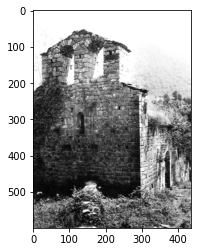

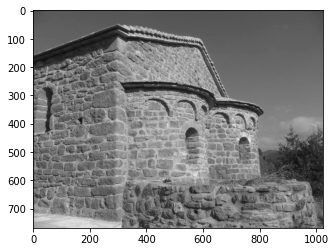

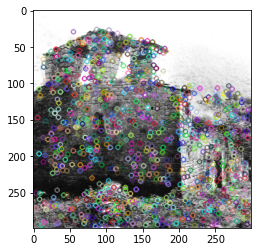

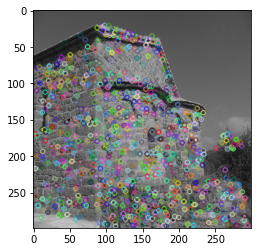

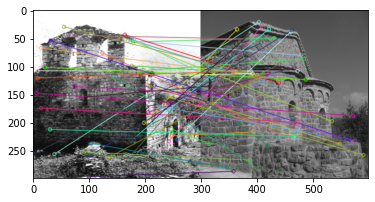

(<matplotlib.image.AxesImage at 0x7fde6c2010d0>, None)

In [ ]:
img = cv2.imread(os.path.join(train_data + '/romanesque' , os.listdir(train_data + '/romanesque')[660]))
img2 = cv2.imread(os.path.join(train_data + '/romanesque' , os.listdir(train_data + '/romanesque')[680]))

def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

def resize(gray_image, target_size=(299,299)):
    return cv2.resize(gray_image, target_size) 

def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))
    plt.show()

img_gray = to_gray(img)
img_gray_res = resize(img_gray)

img2_gray = to_gray(img2)
img2_gray_res = resize(img2_gray)

plt.imshow(img_gray, cmap='gray')
plt.show()
plt.imshow(img2_gray, cmap='gray')
plt.show()

img_kp, img_desc = gen_sift_features(img_gray_res)
show_sift_features(img_gray_res, img, img_kp);

img2_kp, img2_desc = gen_sift_features(img2_gray_res)
show_sift_features(img2_gray_res, img2, img2_kp);

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(img_desc,img2_desc)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(img_gray_res,img_kp,img2_gray_res,img2_kp,matches[:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#pip install tqdm
from tqdm import tqdm

feature_patches = []
for style in os.listdir(train_data):
  print('extracting keypoints / feature patches for images of style {}'.format(style))
  if len(os.listdir(train_data + '/' + style)) > 1500:
    with tqdm(total=int(np.ceil(len(os.listdir(train_data + '/' + style))/2)), position=0, leave=True) as pbar:
      for idx, images in enumerate(os.listdir(train_data + '/' + style)):
        if idx % 2 == 0:
            img = cv2.imread(os.path.join(train_data + '/' + style , images))
            img_gray = to_gray(img)
            img_gray_res = resize(img_gray)
            img_kp, img_desc = gen_sift_features(img_gray_res)
            feature_patches = feature_patches+list(img_desc)
            pbar.update(n=1)
  else:
    with tqdm(total=int(np.ceil(len(os.listdir(train_data + '/' + style)))), position=0, leave=True) as pbar:
      for images in os.listdir(train_data + '/' + style):
            img = cv2.imread(os.path.join(train_data + '/' + style , images))
            img_gray = to_gray(img)
            img_gray_res = resize(img_gray)
            img_kp, img_desc = gen_sift_features(img_gray_res)
            feature_patches = feature_patches+list(img_desc)
            pbar.update(n=1)

extracting keypoints / feature patches for images of style gothic


100%|██████████| 1067/1067 [02:04<00:00,  8.59it/s]


extracting keypoints / feature patches for images of style baroque


100%|██████████| 763/763 [01:53<00:00,  6.75it/s]


extracting keypoints / feature patches for images of style modernism


100%|██████████| 1248/1248 [03:52<00:00,  5.37it/s]


extracting keypoints / feature patches for images of style contemporary


100%|██████████| 889/889 [02:11<00:00,  6.76it/s]


extracting keypoints / feature patches for images of style noucentisme


100%|██████████| 1321/1321 [05:14<00:00,  4.20it/s]


extracting keypoints / feature patches for images of style renaissance


100%|██████████| 339/339 [01:05<00:00,  5.14it/s]


extracting keypoints / feature patches for images of style romanesque


100%|██████████| 1201/1201 [04:49<00:00,  4.14it/s]


extracting keypoints / feature patches for images of style neoclassicism


100%|██████████| 932/932 [03:18<00:00,  4.69it/s]


In [ ]:
np.save(os.path.join(path_to_aml_file,'models/extracted_features/feature_patches.npy'), feature_patches)

In [ ]:
feature_patches = np.load(os.path.join(path_to_aml_file,'models/extracted_features/feature_patches.npy'))

In [ ]:
#@title How many clusters to choose Inertiaplot. res -> k=1600 (don't run if not necessary)

from sklearn.cluster import MiniBatchKMeans

cluster_sizes = [50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600]

def cluster_features(feature_list,number_of_clusters):
    km=MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=number_of_clusters*10)
    km.fit(feature_list)
    return km

inertia_clusters = dict()

for k in cluster_sizes:
  print('Building cluster with k = {}'.format(k))
  cluster_model = cluster_features(feature_patches, k)
  inertia_clusters[k]= cluster_model.inertia_

plt.bar(range(len(inertia_clusters)), list(inertia_clusters.values()), align='center')
plt.xticks(range(len(inertia_clusters)), list(inertia_clusters.keys()))
plt.xlabel("Nr. Of Clusters")
plt.ylabel("Inertia")
plt.show()

Building cluster with k = 50
Building cluster with k = 100
Building cluster with k = 200
Building cluster with k = 400
Building cluster with k = 600
Building cluster with k = 800
Building cluster with k = 1000
Building cluster with k = 1200
Building cluster with k = 1400
Building cluster with k = 1600


In [ ]:
final_cluster = cluster_features(feature_patches, 1600)

In [ ]:
import pandas as pd

def sift_build_vbow(img_path,cluster_model):
    img = cv2.imread(img_path)
    img_gray = to_gray(img)
    img_gray_res = resize(img_gray)
    img_kp, img_desc = gen_sift_features(img_gray_res)
    img_clusters =cluster_model.predict(img_desc) 
    cluster_freq_counts=pd.DataFrame(img_clusters,columns=['cnt'])['cnt'].value_counts()
    bovw_vector=np.zeros(cluster_model.n_clusters)
    for key in cluster_freq_counts.keys():
        bovw_vector[key]=cluster_freq_counts[key]

    bovw_feature=bovw_vector/np.linalg.norm(bovw_vector)
    return list(bovw_feature)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#pip install tqdm
from tqdm import tqdm

train_features = []
train_labels = []
test_features = []
test_labels = []
for style in os.listdir(train_data):
  print('Building final VBOW feature vector for images of style {}'.format(style))
  with tqdm(total=int(np.ceil(len(os.listdir(train_data + '/' + style)))), position=0, leave=True) as pbar:
    for images in os.listdir(train_data + '/' + style):
          path = os.path.join(train_data + '/' + style , images)
          train_features.append(sift_build_vbow(path, final_cluster))
          train_labels.append(style)
          pbar.update(n=1)

for style in os.listdir(test_data):
  print('Building final VBOW feature vector for images of style {}'.format(style))
  with tqdm(total=int(np.ceil(len(os.listdir(test_data + '/' + style)))), position=0, leave=True) as pbar:
    for images in os.listdir(test_data + '/' + style):
          path = os.path.join(test_data + '/' + style , images)
          test_features.append(sift_build_vbow(path, final_cluster))
          test_labels.append(style)
          pbar.update(n=1)

Building final VBOW feature vector for images of style gothic


100%|██████████| 1067/1067 [01:53<00:00,  9.44it/s]


Building final VBOW feature vector for images of style baroque


100%|██████████| 1525/1525 [03:00<00:00,  8.43it/s]


Building final VBOW feature vector for images of style modernism


100%|██████████| 2496/2496 [04:51<00:00,  8.56it/s]


Building final VBOW feature vector for images of style contemporary


100%|██████████| 889/889 [01:20<00:00, 11.02it/s]


Building final VBOW feature vector for images of style noucentisme


100%|██████████| 2642/2642 [05:13<00:00,  8.43it/s]


Building final VBOW feature vector for images of style renaissance


100%|██████████| 339/339 [00:51<00:00,  6.61it/s]


Building final VBOW feature vector for images of style romanesque


100%|██████████| 2401/2401 [05:17<00:00,  7.57it/s]


Building final VBOW feature vector for images of style neoclassicism


100%|██████████| 932/932 [01:30<00:00, 10.32it/s]


Building final VBOW feature vector for images of style renaissance


100%|██████████| 85/85 [02:07<00:00,  1.50s/it]


Building final VBOW feature vector for images of style noucentisme


100%|██████████| 695/695 [01:06<00:00, 10.48it/s]


Building final VBOW feature vector for images of style baroque


100%|██████████| 409/409 [00:55<00:00,  7.35it/s]


Building final VBOW feature vector for images of style gothic


100%|██████████| 264/264 [00:37<00:00,  7.01it/s]


Building final VBOW feature vector for images of style modernism


100%|██████████| 628/628 [01:03<00:00,  9.82it/s]


Building final VBOW feature vector for images of style contemporary


100%|██████████| 221/221 [00:30<00:00,  7.17it/s]


Building final VBOW feature vector for images of style romanesque


100%|██████████| 609/609 [01:00<00:00, 10.14it/s]


Building final VBOW feature vector for images of style neoclassicism


100%|██████████| 224/224 [00:30<00:00,  7.27it/s]


In [ ]:
all_features = np.asarray([(train_features, train_labels), (test_features, test_labels)], dtype=object)
np.save(os.path.join(path_to_aml_file,'models/extracted_features/SIFT_vbow.npy'), all_features)

In [ ]:
(train_features, train_labels), (test_features, test_labels) = np.load(os.path.join(path_to_aml_file,'models/extracted_features/SIFT_vbow.npy'))

In [ ]:
with open(os.path.join(path_to_aml_file,'models/extracted_features/class_encoding.pkl'), 'rb') as f:
    class_encoding = pickle.load(f)

In [ ]:
from keras.utils import to_categorical

train_labels_right_encoding = [class_encoding.get(item,item) for item in train_labels]
train_features_to_concat = []
train_labels_to_concat = []
for encoding in range(0,8):
    for idx, label in enumerate(train_labels_right_encoding):
        if label == encoding:
          train_features_to_concat.append(train_features[idx])
          train_labels_to_concat.append(label)
train_labels_to_concat = to_categorical(train_labels_to_concat)
train_features_to_concat = np.array(train_features_to_concat)
train_labels_to_concat = np.array(train_labels_to_concat)

test_labels_right_encoding = [class_encoding.get(item,item) for item in test_labels]
test_features_to_concat = []
test_labels_to_concat = []
for encoding in range(0,8):
    for idx, label in enumerate(test_labels_right_encoding):
        if label == encoding:
          test_features_to_concat.append(test_features[idx])
          test_labels_to_concat.append(label)
test_labels_to_concat = to_categorical(test_labels_to_concat)
test_features_to_concat = np.array(test_features_to_concat)
test_labels_to_concat = np.array(test_labels_to_concat)

In [ ]:
all_features_to_concat = np.asarray([(train_features_to_concat, train_labels_to_concat), (test_features_to_concat, test_labels_to_concat)], dtype=object)
np.save(os.path.join(path_to_aml_file,'models/extracted_features/SIFT_vbow_to_concat.npy'), all_features_to_concat)